In [39]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage

## Exploratory Analysis

In [40]:
df = pd.read_csv("customer_segmentation_data.csv")

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1000 non-null   int64  
 1   age                   1000 non-null   int64  
 2   gender                1000 non-null   object 
 3   income                1000 non-null   int64  
 4   spending_score        1000 non-null   int64  
 5   membership_years      1000 non-null   int64  
 6   purchase_frequency    1000 non-null   int64  
 7   preferred_category    1000 non-null   object 
 8   last_purchase_amount  1000 non-null   float64
dtypes: float64(1), int64(6), object(2)
memory usage: 70.4+ KB


In [42]:
df.head()

,id,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount
0,1,38,Female,99342,90,3,24,Groceries,113.53
1,2,21,Female,78852,60,2,42,Sports,41.93
2,3,60,Female,126573,30,2,28,Clothing,424.36
3,4,40,Other,47099,74,9,5,Home & Garden,991.93
4,5,65,Female,140621,21,3,25,Electronics,347.08


In [43]:
spending_membership = df[['spending_score', 'membership_years']]
spending_membership.corr()

,spending_score,membership_years
spending_score,1.000000,0.026726
membership_years,0.026726,1.000000


There is no correlation between spending score and customer loyalty as I would think

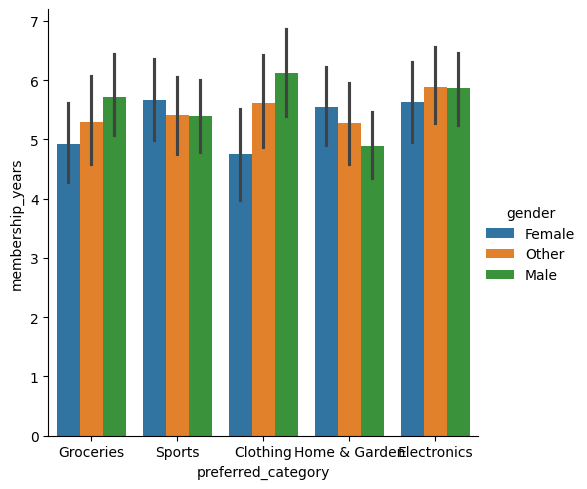

In [44]:
sns.catplot(x="preferred_category", y="membership_years", hue="gender",
    kind="bar", data=df)

Gender differences seems to be relevant in terms of loyalty in certain categories ('Clothing')

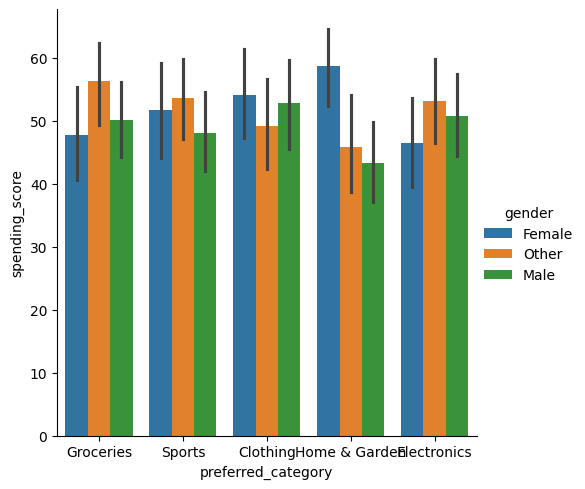

In [45]:
sns.catplot(x="preferred_category", y="spending_score", hue="gender",
    kind="bar", data=df)

The same can be said for spending score: women seems to have an higher spenging score in 'Home & Gardening'

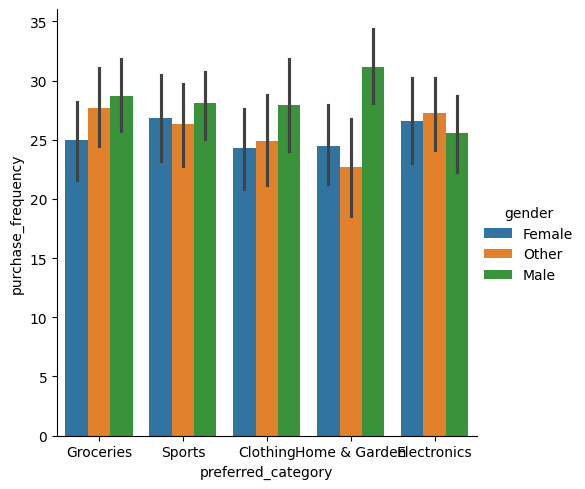

In [46]:
sns.catplot(x="preferred_category", y="purchase_frequency", hue="gender",
    kind="bar", data=df)

'Home and Gargening' category have an higher purchase frequency among men

In [47]:
df.groupby(['preferred_category'])['last_purchase_amount'].agg({'mean', 'min', 'max'})

,max,min,mean
preferred_category,,,
Clothing,997.24,10.40,489.648412
Electronics,998.51,13.16,496.632279
Groceries,992.17,11.01,487.279397
Home & Garden,999.74,11.29,505.600631
Sports,998.98,13.46,481.953190


'Home & Garden' is the categories with higher 'purchase amount' on average

## Data Transformation

In [48]:
bins = [18, 25, 35, 60, 100]
group_names = ["Youth", "YoungAdult", "MiddleAged", "Senior"]

In [49]:
age_categories = pd.cut(df['age'], bins, labels=group_names)
age_categories

0      MiddleAged
1           Youth
2      MiddleAged
3      MiddleAged
4          Senior
          ...    
995    MiddleAged
996         Youth
997         Youth
998         Youth
999    MiddleAged
Name: age, Length: 1000, dtype: category
Categories (4, object): ['Youth' < 'YoungAdult' < 'MiddleAged' < 'Senior']

In [50]:
age_categories.value_counts()

age
MiddleAged    481
YoungAdult    198
Senior        177
Youth         123
Name: count, dtype: int64

In [51]:
df['seniority'] = age_categories

In [52]:
df.groupby('seniority', observed=False)['spending_score'].mean()

seniority
Youth         44.609756
YoungAdult    51.737374
MiddleAged    51.733888
Senior        50.785311
Name: spending_score, dtype: float64

In [53]:
df.groupby('seniority', observed=False)['last_purchase_amount'].mean()

seniority
Youth         478.516829
YoungAdult    478.278384
MiddleAged    496.696258
Senior        514.272316
Name: last_purchase_amount, dtype: float64

In [54]:
income_bins = np.linspace(min(df['income']), max(df['income']), 4)
income_labels = ["lower", "med", "higher"]

In [55]:
income_categories = pd.cut(df['income'], income_bins, labels = income_labels)
income_categories

0         med
1         med
2      higher
3       lower
4      higher
        ...  
995    higher
996     lower
997    higher
998    higher
999       med
Name: income, Length: 1000, dtype: category
Categories (3, object): ['lower' < 'med' < 'higher']

In [56]:
income_categories.value_counts()

income
lower     347
med       340
higher    312
Name: count, dtype: int64

In [57]:
df['income_cat'] = income_categories

In [58]:
seniority_membership = df.groupby(['seniority', 'income_cat'], observed=False)[['membership_years', 'spending_score']].mean()
seniority_membership.reset_index()

,seniority,income_cat,membership_years,spending_score
0,Youth,lower,5.341463,47.146341
1,Youth,med,5.183673,42.265306
2,Youth,higher,4.636364,44.939394
3,YoungAdult,lower,6.013889,52.152778
4,YoungAdult,med,4.818182,53.696970
5,YoungAdult,higher,5.616667,49.083333
6,MiddleAged,lower,5.634731,52.125749
7,MiddleAged,med,5.654762,52.255952
8,MiddleAged,higher,5.544828,50.813793
9,Senior,lower,5.306452,49.161290


## Cluster Analysis

In [59]:
imputer = SimpleImputer(strategy='mean')
df_imputed = imputer.fit_transform(df.select_dtypes(include=[float, int]))

In [60]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_imputed)

In [61]:
encoder = OneHotEncoder(sparse_output=False)
df_categorical = df.select_dtypes(include=[object])
df_encoded = encoder.fit_transform(df_categorical)

In [62]:
df_final = np.hstack((df_scaled, df_encoded))
df_final = pd.DataFrame(df_final)

In [63]:
Z = linkage(df_final, method='ward')

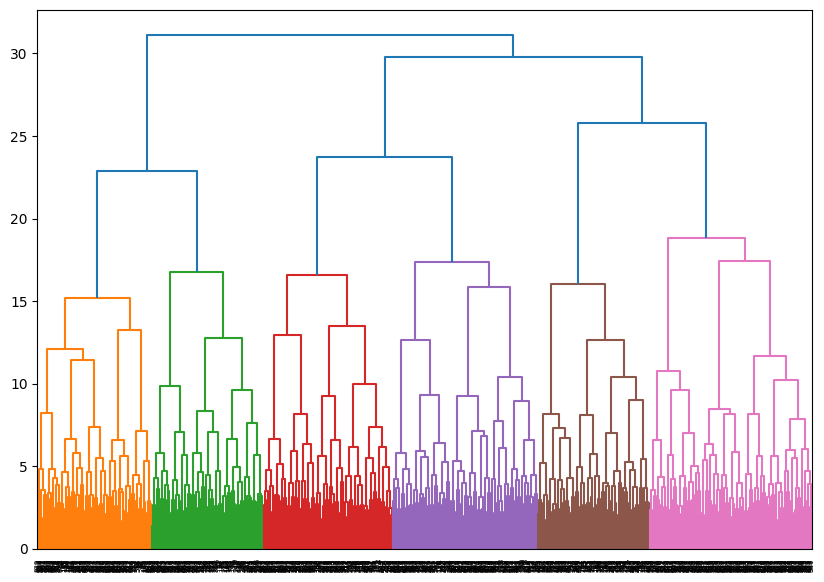

Number of cluster: 5


In [71]:
k = 5  # the clusters number
clusters = fcluster(Z, k, criterion='maxclust')

#Outcome visualization
plt.figure(figsize=(10, 7))
dendrogram(Z, color_threshold=None)
plt.show()

print("Number of cluster:", len(set(clusters)))

In [65]:
# Add clusters to the original dataframe
df['cluster'] = clusters

# Cluster analysis
for cluster in set(clusters):
    print(f"\nCluster {cluster}:")
    print(df[df['cluster'] == cluster].describe())


Cluster 1:
                id         age         income  spending_score  \
count   292.000000  292.000000     292.000000      292.000000   
mean    465.955479   29.530822   90277.797945       37.948630   
std     291.004153    8.788606   32383.321978       24.277903   
min       1.000000   18.000000   30102.000000        1.000000   
25%     195.250000   22.000000   62060.500000       19.000000   
50%     501.000000   29.000000   90488.500000       36.000000   
75%     701.250000   34.000000  114496.500000       53.250000   
max    1000.000000   60.000000  149973.000000       96.000000   

       membership_years  purchase_frequency  last_purchase_amount  cluster  
count        292.000000          292.000000            292.000000    292.0  
mean           5.184932           26.825342            432.189349      1.0  
std            2.767021           14.687126            297.371615      0.0  
min            1.000000            1.000000             14.520000      1.0  
25%            3.

In [66]:
df.groupby('cluster')[['age', 'income', 'spending_score', 'membership_years', 
                       'purchase_frequency', 'last_purchase_amount']].mean()

,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount
cluster,,,,,,
1,29.530822,90277.797945,37.948630,5.184932,26.825342,432.189349
2,55.987952,112441.975904,41.337349,4.084337,24.596386,351.003494
3,53.696809,65283.702128,33.000000,5.664894,25.877660,611.523830
4,46.048611,90738.423611,71.472222,8.097222,32.180556,588.555972
5,43.523810,86355.457143,77.361905,4.980952,24.671429,515.067905


In [74]:
cluster_by_category = df.groupby(['cluster', 'preferred_category'])['id'].count()
cluster_by_category.unstack()

preferred_category,Clothing,Electronics,Groceries,Home & Garden,Sports
cluster,,,,,
1,43,70,62,56,61
2,26,47,27,33,33
3,42,28,31,46,41
4,23,31,24,31,35
5,36,39,55,40,40


Cluster 1 is prevalently composed by young customers attracted by Electronics.

Cluster 2 has got the highiest level of income, even though they don't stand out in terms of loyalty and propensity to consume (purchase_frequency + purchase_amount), they also have a low interest in Clothing.

Cluster 3 has got the lowest level of income and spending score, but with the highest level of propensity to consume.

Cluster 4 -5 instead is determinated by income level and spending score but a different level of loyalty.